# 1.6 signac-flow HOOMD-blue Example

## About

This notebook contains a minimal example for running a *signac-flow* project from scratch.
The example demonstrates how to compare an ideal gas with a Lennard-Jones (LJ) fluid by calculating a p-V phase diagram.

This examples uses the general-purpose simulation toolkit [HOOMD-blue](http://glotzerlab.engin.umich.edu/hoomd-blue/) for the execution of the molecular-dynamics (MD) simulations.

## Author

Carl Simon Adorf, Bradley Dice

## Before you start

This example requires signac, signac-flow, HOOMD-blue and numpy.
You can install these package for example via conda:
```
conda install -c conda-forge hoomd numpy signac signac-flow
```

In [1]:
import flow
import hoomd
import numpy as np
import signac

# Initialize the HOOMD-blue execution context
hoomd.context.initialize("")

project_root = "projects/tutorial-signac-flow-hoomd"


class MyProject(flow.FlowProject):
    pass

HOOMD-blue 2.9.6 DOUBLE HPMC_MIXED TBB SSE SSE2 SSE3 
Compiled: 03/17/2021
Copyright (c) 2009-2019 The Regents of the University of Michigan.
-----
You are using HOOMD-blue. Please cite the following:
* J A Anderson, J Glaser, and S C Glotzer. "HOOMD-blue: A Python package for
  high-performance molecular dynamics and hard particle Monte Carlo
  simulations", Computational Materials Science 173 (2020) 109363
-----
HOOMD-blue is running on the CPU


We want to generate a pressure-volume phase diagram for a Lennard-Jones fluid with molecular dynamics (MD) using the general-purpose simulation toolkit HOOMD-blue (http://glotzerlab.engin.umich.edu/hoomd-blue/).

We start by defining two functions, one for the initialization of our simulation and one for the actual execution.

In [2]:
from math import ceil


def init(N):
    with hoomd.context.SimulationContext():
        n = ceil(pow(N, 1 / 3))
        assert n ** 3 == N
        hoomd.init.create_lattice(unitcell=hoomd.lattice.sc(a=1.0), n=n)
        hoomd.dump.gsd("init.gsd", period=None, group=hoomd.group.all())


def sample_lj(N, sigma, seed, kT, tau, p, tauP, steps, r_cut):
    from hoomd import md

    hoomd.init.read_gsd("init.gsd", restart="restart.gsd")
    group = hoomd.group.all()
    hoomd.dump.gsd("restart.gsd", truncate=True, period=100, phase=0, group=group)
    lj = md.pair.lj(r_cut=r_cut, nlist=md.nlist.cell())
    lj.pair_coeff.set("A", "A", epsilon=1.0, sigma=sigma)
    md.integrate.mode_standard(dt=0.005)
    md.integrate.npt(group=group, kT=kT, tau=tau, P=p, tauP=tauP)
    hoomd.analyze.log("dump.log", ["volume"], 100, phase=0)
    hoomd.run_upto(steps)

We want to use **signac** to manage our simulation data and **signac-flow** to define a workflow acting on the data space.

Now that we have defined the core simulation logic above, it's time to embed those functions into a general *workflow*.
For this purpose we add labels and operations with preconditions/postconditions to `MyProject`, a subclass of `flow.FlowProject`.

The `estimate` operation stores an ideal gas estimation of the volume for the given system.
The `sample` operation actually executes the MD simulation as defined in the previous cell.

In [3]:
@MyProject.label
def estimated(job):
    return "V" in job.document


@MyProject.label
def sampled(job):
    return job.document.get("sample_step", 0) >= 5000


@MyProject.operation
@MyProject.post(estimated)
def estimate(job):
    sp = job.statepoint()
    job.document["V"] = sp["N"] * sp["kT"] / sp["p"]


@MyProject.operation
@MyProject.post(sampled)
def sample(job):
    import hoomd

    with job:
        with hoomd.context.SimulationContext():
            try:
                sample_lj(steps=5000, **job.statepoint())
            finally:
                job.document["sample_step"] = hoomd.get_step()

Now it's time to actually generate some data! Let's initialize the data space!


In [4]:
project = MyProject.init_project(name="FlowTutorialHOOMDProject", root=project_root)

# Uncomment the following two lines if you want to start over!
# for job in project:
#     job.remove()

for p in np.linspace(0.5, 5.0, 10):
    sp = dict(N=512, sigma=1.0, seed=42, kT=1.0, p=p, tau=1.0, tauP=1.0, r_cut=2.5)
    job = project.open_job(sp).init()
    with job:
        init(N=sp["N"])

notice(2): Group "all" created containing 512 particles
notice(2): Group "all" created containing 512 particles
notice(2): Group "all" created containing 512 particles
notice(2): Group "all" created containing 512 particles
notice(2): Group "all" created containing 512 particles
notice(2): Group "all" created containing 512 particles
notice(2): Group "all" created containing 512 particles
notice(2): Group "all" created containing 512 particles
notice(2): Group "all" created containing 512 particles
notice(2): Group "all" created containing 512 particles


The `print_status()` function allows to get a quick overview of our project's *status*:

In [5]:
project.print_status(detailed=True, parameters=["p"])

Fetching status:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching labels:   0%|          | 0/10 [00:00<?, ?it/s]


Overview: 10 jobs, 10 jobs with eligible operations.

label
-------


operation      number of eligible jobs  submission status
-----------  -------------------------  -------------------
estimate                            10  [U]: 10
sample                              10  [U]: 10

Detailed View:

job id                            operation       p  labels
--------------------------------  ------------  ---  --------
18c063206c37ab03d06de130c6ae2b70  estimate [U]  1
                                  sample [U]    1
2a05a487f254db90b08f576d199a83b7  estimate [U]  5
                                  sample [U]    5
4ef567c185064a4b27b73f62124991c0  estimate [U]  3
                                  sample [U]    3
5b3c8f0fbd9458a304222d83bb82bc30  estimate [U]  3.5
                                  sample [U]    3.5
6681f083e2b03f5b9816f35502e411f7  estimate [U]  1.5
                                  sample [U]    1.5
6ff6b952b42f0ad3e1315e137cf67cdb  estimate [U]  4
                  

The next cell will attempt to execute all eligible operations.

In [6]:
project.run()

notice(2): Group "all" created containing 512 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 512
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:04 | Step 5000 / 5000 | TPS 1227.09 | ETA 00:00:00
Average TPS: 1226.85
---------
-- Neighborlist stats:
316 normal updates / 50 forced updates / 0 dangerous updates
n_neigh_min: 0 / n_neigh_max: 104 / n_neigh_avg: 51.2246
shortest rebuild period: 3
-- Cell list stats:
Dimension: 2, 2, 2
n_min    : 60 / n_max: 68 / n_avg: 64
** run complete **
notice(2): Group "all" created containing 512 particles
notice(2): -- Neighborlist exclusion statistics -- :
notice(2): Particles with 0 exclusions             : 512
notice(2): Neighbors included by diameter          : no
notice(2): Neighbors excluded when in the same body: no
** starting run **
Time 00:00:03 | Step 5000 / 5000 | TPS 1523.76 | 

Let's double check the project status.

In [7]:
project.print_status(detailed=True)

Fetching status:   0%|          | 0/20 [00:00<?, ?it/s]

Fetching labels:   0%|          | 0/10 [00:00<?, ?it/s]


Overview: 10 jobs, 0 jobs with eligible operations.

label      ratio
---------  ----------------------------------------------------------
estimated  |████████████████████████████████████████| 10/10 (100.00%)
sampled    |████████████████████████████████████████| 10/10 (100.00%)

operation
-----------


Detailed View:

job id                            operation    labels
--------------------------------  -----------  ------------------
18c063206c37ab03d06de130c6ae2b70  [ ]          estimated, sampled
2a05a487f254db90b08f576d199a83b7  [ ]          estimated, sampled
4ef567c185064a4b27b73f62124991c0  [ ]          estimated, sampled
5b3c8f0fbd9458a304222d83bb82bc30  [ ]          estimated, sampled
6681f083e2b03f5b9816f35502e411f7  [ ]          estimated, sampled
6ff6b952b42f0ad3e1315e137cf67cdb  [ ]          estimated, sampled
99f5397cf2f6250afe34927606aa2f37  [ ]          estimated, sampled
a5d4427e8d285c78239005f740a2625b  [ ]          estimated, sampled
a89bc9f5cceaf268f18efed936a703

After running all operations we can make a brief examination of the collected data.

In [8]:
def get_volume(job):
    log = np.genfromtxt(job.fn("dump.log"), names=True)
    N = len(log)
    return log[int(0.5 * N) :]["volume"].mean(axis=0)


for job in project:
    print(job.statepoint["p"], get_volume(job), job.document.get("V"))

3.5 629.75796286 146.28571428571428
0.5 1146.859093668 1024.0
1.5 789.514068364 341.3333333333333
2.0 723.460173872 256.0
4.0 614.63846208 128.0
1.0 905.471509388 512.0
4.5 599.651218704 113.77777777777777
5.0 589.6517064440001 102.4
3.0 657.398353356 170.66666666666666
2.5 692.0376509839999 204.8


For a better presentation of the results we need to aggregate all results and sort them by pressure.

*The following code requires matplotlib.*

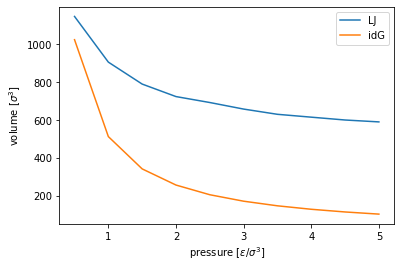

In [9]:
%matplotlib inline
# Display plots within the notebook

from matplotlib import pyplot as plt

V = dict()
V_idg = dict()

for job in project:
    V[job.statepoint()["p"]] = get_volume(job)
    V_idg[job.statepoint()["p"]] = job.document["V"]

p = sorted(V.keys())
V = [V[p_] for p_ in p]
V_idg = [V_idg[p_] for p_ in p]

plt.plot(p, V, label="LJ")
plt.plot(p, V_idg, label="idG")
plt.xlabel(r"pressure [$\epsilon / \sigma^3$]")
plt.ylabel(r"volume [$\sigma^3$]")
plt.legend()
plt.show()

Uncomment and execute the following line to remove all data and start over.

In [10]:
# %rm -r projects/tutorial-signac-flow-hoomd-blue/workspace